In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/kichanglee/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


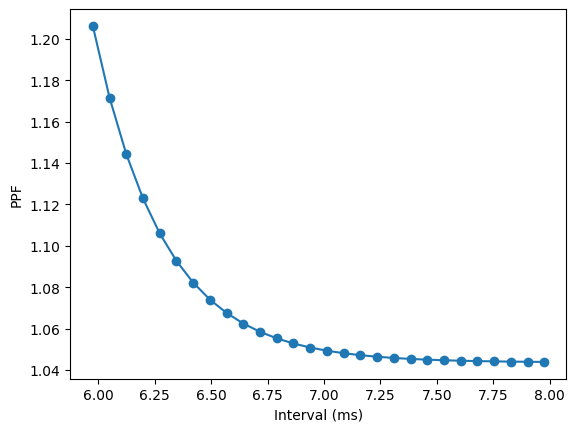

In [155]:
df = pd.read_csv('fitted_data.csv', encoding='utf-8')
# TODO: Change column titie
df.columns = ['time', 'value']
t = df['time'].to_numpy()[:28]
ppf_v = df['value'].to_numpy()[:28]/100
plt.plot(t, ppf_v, 'o-', label='data')
plt.xlabel('Interval (ms)')
plt.ylabel('PPF')
plt.show()

In [10]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [119]:
def preprocess_sample(sample, ppf_v):
    """
    Preprocess a single MNIST sample.

    Args:
        sample (Tensor): A single MNIST image tensor (shape: [28, 28]).
        ppf_v (list or numpy array): The array of values used for the transformation.

    Returns:
        Tensor: Transformed image tensor.
    """
    current = torch.ones(28)  # Initialize current array
    sample = sample.clone()  # Avoid modifying the original tensor

    for ridx, row in enumerate(sample):
        non_zero = row != 0
        row[non_zero] = 1
        count = 0

        for cidx, value in enumerate(row):
            if value == 1:
                current[cidx] *= ppf_v[count]
                count = 0
            else:
                current[cidx] *= 0.99
                count += 1
    return current

def preprocess_sample_col(sample, ppf_v):
    """
    Preprocess a single MNIST sample.

    Args:
        sample (Tensor): A single MNIST image tensor (shape: [28, 28]).
        ppf_v (list or numpy array): The array of values used for the transformation.

    Returns:
        Tensor: Transformed image tensor.
    """
    current = torch.ones(28)  # Initialize current array
    sample = sample.clone()  # Avoid modifying the original tensor

    for ridx, row in enumerate(sample.T):
        non_zero = row != 0
        row[non_zero] = 1
        count = 0

        for cidx, value in enumerate(row):
            if value == 1:
                current[cidx] *= ppf_v[count]
                count = 0
            else:
                current[cidx] *= 0.99
                count += 1
    return current
    
mnist_train = dsets.MNIST(root='MNIST_data/', train=True, transform=transforms.Compose([transforms.ToTensor()]), download=False)
mnist_test = dsets.MNIST(root='MNIST_data/', train=False, transform=transforms.Compose([transforms.ToTensor()]), download=False)

In [91]:
from tqdm import tqdm

In [120]:
train_data_col = []
for d in tqdm(mnist_train.data):
    train_data_col.append(preprocess_sample_col(d, ppf_v))

with open('train_data_col.npy', 'wb') as f:
    np.save(f, train_data_col)

test_data_col = []
for d in tqdm(mnist_test.data):
    test_data_col.append(preprocess_sample_col(d, ppf_v))

with open('test_data_col.npy', 'wb') as f:
    np.save(f, test_data_col)

100%|██████████| 10000/10000 [02:11<00:00, 76.03it/s]


In [130]:
import torch.nn as nn 

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(56, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [123]:
np.concatenate([train_data_col, train_data], axis=1).shape

(60000, 56)

In [124]:
mnist_train.data = torch.tensor(np.concatenate([train_data_col, train_data], axis=1))
mnist_test.data = torch.tensor(np.concatenate([test_data_col, test_data], axis=1))
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=100, shuffle=False)

In [125]:
print(mnist_test.data.shape)

torch.Size([10000, 56])


In [ ]:
loss_fn = nn.CrossEntropyLoss()
model = SimpleNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
acc_trace = []
loss_trace = []
for epoch in range(10):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 56).to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        correct = 0
        total = 0
        if i % 10 == 0:    
            loss = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.view(-1, 56).to(DEVICE)
                    labels = labels.to(DEVICE)

                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    loss += loss_fn(outputs, labels)

                    total += labels.size(0)
                    correct += (predicted == labels).sum()
            acc_trace.append(100 * correct/total)
            loss_trace.append(loss.item()/len(test_loader))
        


AttributeError: module 'numpy' has no attribute 'arnge'

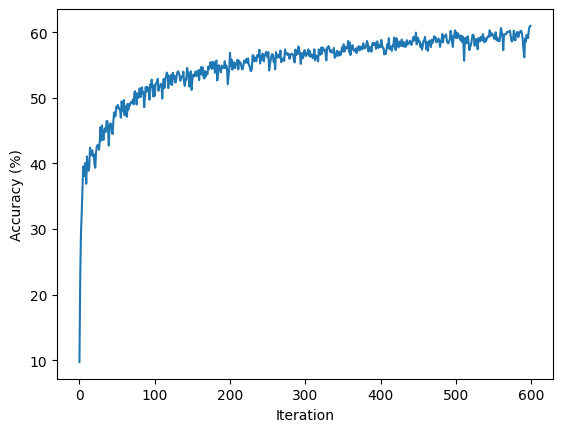

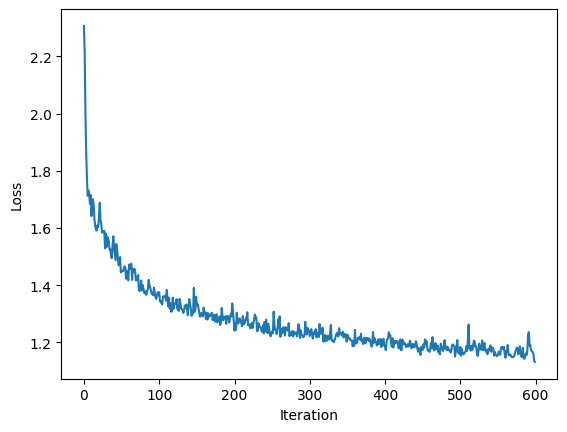

In [145]:
plt.plot(np.arange(60*10), acc_trace)
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.show()
plt.plot(np.arange(60*10),loss_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()    

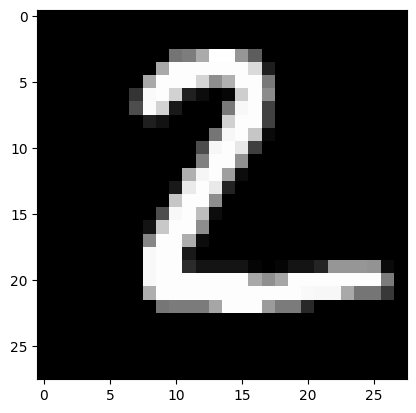

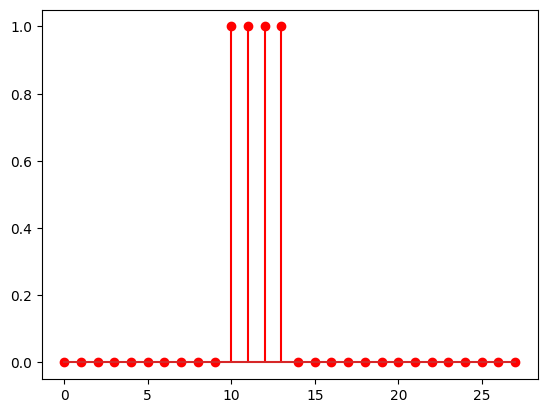

In [153]:

mnist_test_ = dsets.MNIST(root='MNIST_data/', train=False, transform=transforms.Compose([transforms.ToTensor()]), download=False)
sample = mnist_test_.data[1]

plt.imshow(sample, cmap='gray')
plt.show()
t = np.arange(0, 28)
currents = []
labels   = []
for sidx, sample in enumerate(mnist_test_.data[1:2]):
    current = np.ones(28)        
    non_zero = sample!=0
    sample[non_zero] = 1
    count = 0
    row = sample[14]
plt.stem(row, 'r')
plt.show()

In [54]:
from sklearn.manifold import TSNE

# Convert currents list to numpy array
currents_array = np.array(currents)

# Apply TSNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=0)
currents_2d = tsne.fit_transform(currents_array)


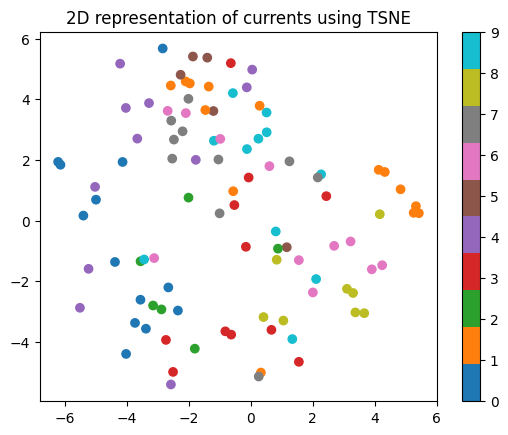

In [50]:

# Plot the 2D representation
plt.scatter(currents_2d[:, 0], currents_2d[:, 1], c=[label.item() for label in labels], cmap='tab10')
plt.colorbar()
plt.title('2D representation of currents using TSNE')
plt.show()

RuntimeError: Boolean value of Tensor with more than one value is ambiguous